Nakagami Distribution

In [1]:
import numpy as np
from numpy import ndarray
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot_2samples, qqplot
import scipy
from scipy.signal import lfilter
from scipy.stats import norm, uniform, triang, probplot
from scipy.special import erfinv, eval_hermitenorm
from scipy.integrate import quad
import scipy.io
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def findCoeff(dist_obj = uniform):
    """
    This function will find the d coefficients.

    Input:
    dist_obj - A scipy.stats target distribution we want to get d coefficients of.

    Output:
    d        - A list of d coefficients, np.shape = (numberOfHermitePoly, ),
               representing the chosen distribution.
    """
    firstDegreeOfHermitePoly = 1
    threshold_for_small_d_coeff = 10**-6
    max_amount_of_poly = 8
    amount_of_consecutive_zeroes = 2

    integrationMin = dist_obj.ppf(1e-15)  # The minimum value of x for which Fy(x) is defined
    integrationMax = dist_obj.ppf(1-1e-15)  # The maximum value of x for which Fy(x) is defined
    d = []
    num_zeros = 0 # count zeroes in polynomials
    numberOfHermitePoly = firstDegreeOfHermitePoly
    while True:
      I = quad(integration_function, integrationMin, integrationMax, args=(numberOfHermitePoly, dist_obj))
      current_d = I[0]**2/np.math.factorial(numberOfHermitePoly)
      if numberOfHermitePoly > firstDegreeOfHermitePoly:
        d_check = current_d/sum(d)
        if d_check < threshold_for_small_d_coeff:
          num_zeros += 1
        else:
          num_zeros = 0 # reset zeros counter
        if num_zeros == amount_of_consecutive_zeroes or numberOfHermitePoly == max_amount_of_poly:
          break
      d.append(current_d)
      numberOfHermitePoly += 1
    d = [x / sum(d) for x in d]
    return d

def integration_function(y, numberOfHermitePoly, dist_obj):
    """
    This function will find the integration function that helps in finding
    the d coefficients.

    Input:
    y                   - Integration variable (comes from quad() function).
    numberOfHermitePoly - Number of the order of the hermite polynomial.
    dist_obj            - A scipy.stats target distribution.

    Integration function that results with the d coefficients.
    """
    fx = lambda x: norm.pdf(x) # normal distribution PDF
    fy = lambda x: dist_obj.pdf(x) # desired distribution PDF
    Fy = lambda x: dist_obj.cdf(x) # desired distribution CDF
    h = lambda x: np.sqrt(2)*erfinv(2*x-1) 
    hdot = lambda x,y: np.sqrt(2*np.pi)*x*np.exp(erfinv(2*y-1)**2)
    hermiteProb = lambda n,x: eval_hermitenorm(n,x) # hermite polynom
    return y * hermiteProb(numberOfHermitePoly,h(Fy(y))) * fx(h(Fy(y))) * hdot(fy(y),Fy(y)) # The integration function

def find_ro_x(d, desiredACF):
  """
  This function will find the approximation of the target ACF.
  
  Input:
  d          - d coefficients.
  desiredACF - The target ACF.

  Output:
  ro_x       - Approximation of the target ACF with the usage of the
               d coefficients, size = (length(desiredACF), ).
  """
  ro_x = []
  ### calculation of ro x
  for Roy in desiredACF:
    coeff = d[::-1]
    coeff.append(-Roy)
    Rox = np.poly1d(coeff)
    roots = np.roots(Rox)[np.iscomplex(np.roots(Rox)) == False]
    roots = np.real(roots)[np.real(roots) >= -1.05]
    roots = roots[roots <= 1.05]
    ro_x.extend(np.real(roots))
  return ro_x


# %% MSE cost function for ARMA optimization
def mse(result: np.ndarray, target: np.ndarray) -> np.ndarray:
    """Mean Squared Error"""
    score = np.mean(np.square(np.clip(result, -1e5, 1e5) - target))
    return score


# %% ar, ma <-> vector
def ar_ma_to_vector(ar: np.ndarray, ma: np.ndarray) -> np.ndarray:
    """Convert ARMA to vector"""
    return np.concatenate((ar[1:], ma[1:]))


def vector_to_ar_ma(x: np.ndarray) -> (np.ndarray, np.ndarray):
    """Convert vector to ARMA"""
    ar = np.zeros(4)
    ar[0] = 1
    ar[1:] = x[:3]
    ma = np.zeros(4)
    ma[0] = 1
    ma[1:] = x[3:]
    return ar, ma


# %% theoretical ACF
def my_arma_acf(x, lags: int) -> np.ndarray:
    """ARMA(3,3) model
    output: theoretical ACF
    """
    ar, ma = vector_to_ar_ma(x)
    return arma_acf(ar, ma, lags)



# %% Optimization cost function
def cost_function(x, lags, target_acf):
    """Cost function for ARMA optimization
    input:
    x - vector of ARMA coefficients
    lags - amount of lag in the autocorrelation
    """
    try:
        R = my_arma_acf(x, lags) # theoretical ACF
    except:
        return 1e10
    return mse(R, target_acf)


# %% ARMA model
def get_arma_filter(target_acf):
    lags = len(target_acf)
    x0 = np.array([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5])
    res = minimize(cost_function, x0, args=(lags, target_acf), method='nelder-mead',
                   options={'xatol': 1e-5, 'disp': True})
    ar, ma = vector_to_ar_ma(res.x)
    return ar, ma


def get_ranked_sequence(x, z):
  """
    This function will apply the rank matching operation.
    
    Input:
    x - Gaussian sequence with the desired ACF.
    z - Target distribution sequence without the desired ACF.

    Output:
    y - Target distribution sequence with the desired ACF, np.shape = (length(x), ).
  """
  I = np.argsort(x)
  y = np.sort(z)
  y[I] = y.copy()
  return y

  
def debugPlots(dist_obj, desiredACF, y):
  """
  This Function will draw plots of the achieved PDF and ACF.

  Input:
  dist_obj - The target distribution object
  desiredACF - The target ACF 
  y - The final sequence with matching ACF and distribution to the target

  """  
  kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, ec="k")
  yCorr = sm.tsa.acf(y, nlags = len(desiredACF)-1, fft = True)
  plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1),  
    "axes.facecolor":    (1.0, 1.0, 1.0, 1),  
    "savefig.facecolor": (1.0, 1.0, 1.0, 1), 
    })


  plt.subplot(311)
  pdfxAxis = np.linspace(dist_obj.ppf(1e-15), dist_obj.ppf(1-1e-15), 1000)
  plt.title('Resulting PDF')
  plt.rcParams["figure.figsize"] = (8,4)
  plt.rcParams['figure.dpi'] = 100
  plt.plot(pdfxAxis, dist_obj.pdf(pdfxAxis), label = "Required PDF")
  plt.hist(y, bins='auto', label = "Simulated PDF", **kwargs)
  plt.xlabel('x')
  plt.ylabel('P(x)')
  plt.grid(True)
  plt.legend(loc='upper right')

  plt.subplot(312)
  plt.title('Resulting ACF')
  plt.rcParams["figure.figsize"] = (8,4)
  plt.rcParams['figure.dpi'] = 100
  plt.plot(yCorr, '-.', label = 'Simulated ACF')
  plt.plot(desiredACF, '--', alpha = 0.5, label = 'Required ACF')
  plt.xlabel('Lags')
  plt.ylabel('ACC')
  plt.legend(loc='upper right')
  plt.grid(True)

  plt.subplot(313)
  ax1 = plt.gca()
  qqplot(y, fit=False, line='45', dist=dist_obj, ax = ax1)
  fig = plt.gcf()
  fig.set_size_inches(5, 15)
  ax1.set_title('Distribution Q-Q Plot')
  ax1.set_xlabel('Theoretical Quantiles')
  ax1.set_ylabel('Sample Quantiles')
  ax1.grid(True)
  plt.show()

  

def generate_corr_sequence(dist_obj = uniform,
                           desiredACF = 1 - np.minimum(np.arange(0,100),100)/100,
                           L = 2**20, seed = 100,
                           debug=False, showGauss=False):
  """
  This Function will create a vector (sequence) of samples with the desired
  AutoCorrelation Function and distribution.

  Input:
  dist_obj   - The deisred distibution, default is uniform.
  desiredACF - Vector of the target ACF function.
  L          - Number of samples in the output sequence, default is 2^20.
  seed       - Seed for the random number generator.
  debug      - Whether to plot debugging graphs or not, default is False.

  Output:
  y          - An np.ndarray of samples with desired ACF and PDF, np.shape = (L, ).
  """  

  np.random.seed(seed)

  d = findCoeff(dist_obj)

  ro_x = find_ro_x(d, desiredACF)

  Xn = np.random.normal(size=L) # normal sequence

  ar, ma = get_arma_filter(ro_x) # finding the appropriate filter to get the target ACF

  x = lfilter(ma, ar, Xn)
  
  if showGauss:
    debugPlots(dist_obj, desiredACF, x)

  z = dist_obj.rvs(size=L) # Desired distribution sequence

  y = get_ranked_sequence(x, z) # rank matching the sequence

  if debug:
    debugPlots(dist_obj, desiredACF, y)

  return y

Optimization terminated successfully.
         Current function value: 0.007176
         Iterations: 561
         Function evaluations: 913


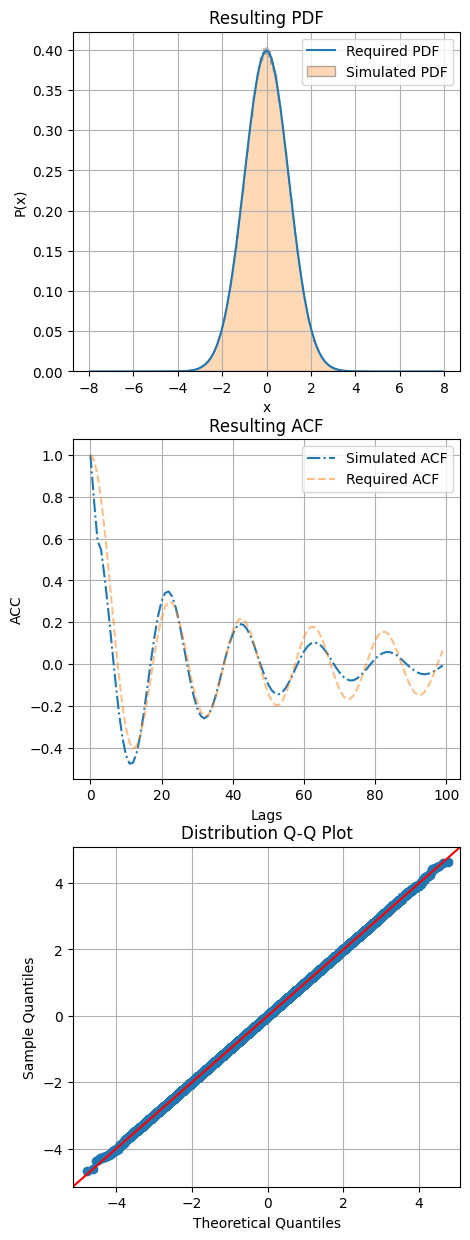

array([-0.82089231, -0.47819486,  0.64655173, ...,  1.13595198,
        1.50217037,  0.95264912])

In [2]:
from scipy.stats import nakagami
from scipy.special import j0
m = np.arange(0,100)
generate_corr_sequence(dist_obj = norm, desiredACF = np.array(j0(0.1*np.pi*abs(m))), debug=True)